In [53]:
import gymnasium as gym 
from gymnasium import spaces
import numpy as np
import torch as th
import os
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
from stable_baselines3 import SAC
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import BaseCallback
import pickle

In [54]:
class MAB(gym.Env):
    def __init__(self, probs, T):
        """
        初始化多臂老虎机环境
        probs: 每个臂的成功概率
        T: 总时间步数
        """
        super(MAB, self).__init__()
        self.k = len(probs)  # 臂的数量
        self.probs = probs  # 每个臂的成功概率
        self.T = T  # 总时间步数

        # 定义动作空间和观察空间
        self.action_space = spaces.Box(low=1, high=100, shape=(1,), dtype=np.float32)  # 动作空间为alpha\in[1,100]代指UCB算法中的探索因子
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(3 * self.k + 1,))  # 观察空间为(3*k+1)维向量，每个维度包含三个元素：拉臂的次数、获得的奖励、奖励的方差，以及最后一个元素是时间t
        self.reset()

    def reset(self, seed=None, options=None):
        """
        重置环境
        返回: 初始状态
        """
        super().reset(seed=seed)
        self.steps = 0
        self.n = np.zeros(self.k)  # 每个臂的拉动次数
        self.average_rewards = np.zeros(self.k)  # 每个臂奖励的均值
        self.rewards = [[] for _ in range(self.k)]  # 每个臂的奖励列表
        self.var = np.zeros(self.k) # 每个臂奖励的方差
        self.alpha = 1.0  # 初始alpha值
        observation = np.zeros(3 * self.k + 1)  # 初始状态
        info = {}
        return observation, info
    
    def step(self, action):
        """
        执行给定的动作，并返回结果。
        
        参数:
        action: 智能体选择的alpha值
        
        返回:
        - next_state: 执行动作后的新状态
        - reward: 执行动作后获得的奖励
        - terminated: 布尔值，表示是否达到终止状态
        - truncated: 布尔值，表示是否由于时间限制或其他原因而被截断
        - info: 额外的诊断信息（可选）
        """
        self.alpha = action[0]  # 更新alpha值

        ucb_values = self.average_rewards + np.sqrt(self.alpha * np.log(self.steps + 1) / (2 * (self.n + 1e-10)))
        chosen_arm = np.argmax(ucb_values)  # 选择具有最高UCB值的臂
        reward = np.random.binomial(1, self.probs[chosen_arm])  # 根据奖励概率生成奖励
        
        self.steps += 1
        self.n[chosen_arm] += 1
        self.rewards[chosen_arm].append(reward)  # 更新奖励列表
        self.average_rewards[chosen_arm] = np.mean(self.rewards[chosen_arm])  # 更新奖励均值
        self.var[chosen_arm] = np.var(self.rewards[chosen_arm])#更新奖励方差
        terminated = self.steps >= self.T  # 判断是否达到最大步数
        truncated = self.steps >= self.T  # 在这个示例中，截断条件与终止条件相同
        next_state = np.concatenate([self.n, self.average_rewards, self.var, [self.steps]])  # 更新状态
        info = {} # 可选的额外信息

        return next_state, reward, terminated, truncated, info


In [55]:

def get_reward_episode(model_name, env, T, n_episodes,is_print=False):
    """
    用训练出的策略模型,在确定和随机的条件下,与分别环境进行n_episodes交互,分别计算各步累计收益的平均值,并绘制平均收益和平均的alpha随时间步的变化
    """
    # 初始化确定策略和随机策略的各步的平均累计收益(n_episdodes次交互的总和)
    deterministic_rewards_sum = np.zeros(T)
    stochastic_rewards_sum = np.zeros(T)
    # 初始化确定策略和随机策略的各步的平均alpha
    deterministic_alphas_sum = np.zeros(T)
    stochastic_alphas_sum = np.zeros(T) 

    for episode_index in range(n_episodes):
        # 初始化确定策略每步的累计收益
        deterministic_reward_episode = np.zeros(T)
        # 重置环境，获取初始状态
        state, _ = env.reset()
        # 确定策略与环境进行交互
        for t in range(T):
            # 将状态转换为 PyTorch 张量，并添加批量维度
            state_tensor = th.tensor(state, dtype=th.float32).unsqueeze(0)
            # 确定性策略
            action, _ = model_name.predict(state_tensor, deterministic=True)
            next_state, reward, terminated, truncated, info = env.step(action)
            # 更新确定策略的累计收益
            if t == 0:
                deterministic_reward_episode[t] = reward
            else:
                deterministic_reward_episode[t] = reward+deterministic_reward_episode[t-1]
            # 更新确定策略的累计alpha
            deterministic_alphas_sum[t] += action
            # 与环境交互
            state = next_state
        # 加上确定策略的本次交互的累计收益
        deterministic_rewards_sum += deterministic_reward_episode
        # 初始化随机策略每步的累计收益
        stochastic_reward_episode = np.zeros(T)
        # 重置环境，获取初始状态
        state, _ = env.reset()
        # 随机策略与环境进行交互
        for t in range(T):
            # 将状态转换为 PyTorch 张量，并添加批量维度
            state_tensor = th.tensor(state, dtype=th.float32).unsqueeze(0)
            # 随机性策略
            action, _ = model_name.predict(state_tensor, deterministic=False)
            next_state, reward, terminated, truncated, info = env.step(action)
            # 更新随机策略的累计收益
            if t == 0:
                stochastic_reward_episode[t] = reward
            else:
                stochastic_reward_episode[t] = reward+stochastic_reward_episode[t-1]
            # 更新随机策略的累计alpha
            stochastic_alphas_sum[t] += action
            # 与环境交互
            state = next_state
        # 加上随机策略的本次交互的累计收益
        stochastic_rewards_sum += stochastic_reward_episode
        if is_print:
            print('Episode:', episode_index + 1)
    # 计算episode内确定策略和随机策略的每步的平均累计收益
    deterministic_rewards_mean = deterministic_rewards_sum / n_episodes
    stochastic_rewards_mean = stochastic_rewards_sum / n_episodes
    # 计算episode内确定策略和随机策略的每步的平均alpha
    deterministic_alphas_mean = deterministic_alphas_sum / n_episodes
    stochastic_alphas_mean = stochastic_alphas_sum / n_episodes
    return deterministic_rewards_mean, stochastic_rewards_mean, deterministic_alphas_mean, stochastic_alphas_mean

进行多轮训练

按一定轮次的频率保存训练所得的策略

后续读取训练结果，绘出平均最终收益随训练轮次的变化情况


重点关注参数：
参数名      | 描述 |
| ----------- | ----------- |
| probs      | 多臂老虎机设定       |
| T      | 每轮拉臂的次数       |
| total_timesteps      | 总训练轮数       |
| check_freq      | 训练结果保存频率       |

In [56]:
# 创建环境
np.random.seed(1)
probs = np.random.rand(5)
formatted_probs = [f"{prob:.4f}" for prob in probs]
print("伯努利多臂老虎机的概率为：", formatted_probs)
T = 50
env = MAB(probs,T)
class SaveOnBestTrainingRewardCallback(BaseCallback):
    def __init__(self, check_freq: int, save_path: str, verbose: int = 1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self) -> None:
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            model_filename = f'model_{self.n_calls}.zip'
            model_path = os.path.join(self.save_path, model_filename)
            self.model.save(model_path)
            if self.verbose > 0:
                print(f"Saving model checkpoint to {model_filename}")
                print(f"Model {model_filename} has been saved.")
        return True
    
# 定义保存路径和检查频率
save_path = '/Users/fengyilong/Git/MAB_SAC/UCB_record'
check_freq = 1000

# 创建回调函数实例
callback = SaveOnBestTrainingRewardCallback(check_freq=check_freq, save_path=save_path)

# 创建模型
model = SAC("MlpPolicy", env, gamma=1, verbose=2)

total_timesteps = 100000

# 训练模型并使用回调函数
model.learn(total_timesteps, callback=callback)

model.save("UCB")


伯努利多臂老虎机的概率为： ['0.4170', '0.7203', '0.0001', '0.3023', '0.1468']
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | 19       |
| time/              |          |
|    episodes        | 4        |
|    fps             | 207      |
|    time_elapsed    | 0        |
|    total_timesteps | 200      |
| train/             |          |
|    actor_loss      | -1.93    |
|    critic_loss     | 0.276    |
|    ent_coef        | 0.97     |
|    ent_coef_loss   | -0.051   |
|    learning_rate   | 0.0003   |
|    n_updates       | 99       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | 19.4     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 144      |
|    time_elapsed    | 2 

与环境交互一次的示例

伯努利多臂老虎机的概率为： ['0.4170', '0.7203', '0.0001', '0.3023', '0.1468']
随机策略拉臂次数: [25.  5.  7.  7.]
随机策略臂收益均值: [0.1667 0.68   0.     0.2857 0.2857]
随机策略臂收益方差: [0.1389 0.2176 0.     0.2041 0.2041]
随机策略总收益: 22.0


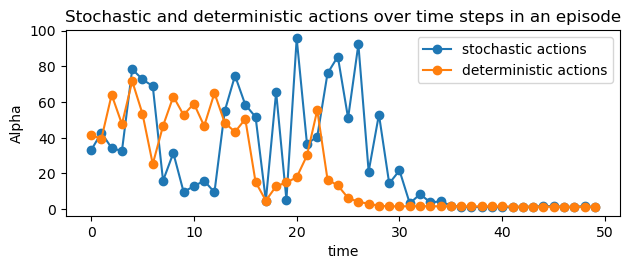

伯努利多臂老虎机的概率为： ['0.4170', '0.7203', '0.0001', '0.3023', '0.1468']
确定策略拉臂次数: [10. 26.  4.  4.  6.]
确定策略臂收益均值: [0.4    0.5385 0.     0.     0.1667]
确定策略臂收益方差: [0.24   0.2485 0.     0.     0.1389]
确定策略总收益: 19.0


In [57]:
# 与环境交互一次的示例
# 加载训练好的模型
model_name = SAC.load("UCB")

# 重置环境，获取初始状态
state, _ = env.reset()

# 确保状态是一个 NumPy 数组
state = np.array(state)

# 初始化随机策略记录均值、标准差和动作的列表
means1 = []
stds1 = []
actions1 = []#记录随机性策略的动作

# 注意，分了两个循环，一个是随机性策略，一个是确定性策略；不同情形下的状态游走路径可能是不一样的

# 随机性策略交互
for t in range(T):
    # 将状态转换为 PyTorch 张量，并添加批量维度
    state_tensor = th.tensor(state, dtype=th.float32).unsqueeze(0)
    action1, _ = model_name.predict(state_tensor, deterministic=False) #  随机策略，高斯分布采样+裁剪

    # 获取动作分布参数
    mean_actions, log_std, _ = model_name.policy.actor.get_action_dist_params(state_tensor)
    std = th.exp(log_std)
    # 记录均值和标准差
    means1.append(mean_actions.detach().numpy().flatten())
    stds1.append(std.detach().numpy().flatten())
    actions1.append(action1)
    # 与环境进行交互
    next_state, reward, terminated, truncated, info = env.step(action1)

    # 更新状态
    state = next_state

# 将均值、标准差和实际动作转换为 NumPy 数组
means1 = np.array(means1)
stds1 = np.array(stds1)
actions1 = np.array(actions1)

k = len(probs)
self_n = state[:k]
self_average_rewards = state[k:2*k]
total_reward = np.sum(self_n * self_average_rewards)
# 打印最终状态和总收益
formatted_probs = [f"{prob:.4f}" for prob in probs]
print("伯努利多臂老虎机的概率为：", formatted_probs)
print("随机策略拉臂次数:", state[1:k])
print("随机策略臂收益均值:",np.round(state[k:2*k], 4))
print("随机策略臂收益方差:",np.round(state[2*k:3*k], 4))
print("随机策略总收益:", total_reward)


# 重置环境，获取初始状态
state, _ = env.reset()
# 初始化确定策略记录均值、标准差和动作的列表
means2 = []
stds2 = []
actions2 = []#记录确定性策略的动作

# 确定性策略交互
for t in range(T):
    # 将状态转换为 PyTorch 张量，并添加批量维度
    state_tensor = th.tensor(state, dtype=th.float32).unsqueeze(0)
    action2, _ = model_name.predict(state_tensor, deterministic=True) #  确定性策略，均值动作
    # 记录动作
    actions2.append(action2)
    # 获取动作分布参数
    mean_actions, log_std, _ = model_name.policy.actor.get_action_dist_params(state_tensor)
    std = th.exp(log_std)
    # 记录均值和标准差
    means2.append(mean_actions.detach().numpy().flatten())
    stds2.append(std.detach().numpy().flatten())
    # 与环境进行交互
    next_state, reward, terminated, truncated, info = env.step(action2)

    # 更新状态
    state = next_state
# 将实际动作转换为 NumPy 数组
means2 = np.array(means2)
stds2 = np.array(stds2)
actions2 = np.array(actions2)
time_steps = np.arange(T)

# 绘制随机策略的动作随时间步的变化
plt.subplot(2, 1, 2)
plt.plot(time_steps, actions1.flatten(), '-o', label='stochastic actions')
# 绘制确定策略的动作随时间步的变化
plt.plot(time_steps, actions2.flatten(), '-o', label='deterministic actions')
plt.xlabel('time')
plt.ylabel('Alpha')
plt.title('Stochastic and deterministic actions over time steps in an episode')
plt.legend()

plt.tight_layout()
plt.show()

k = len(probs)
self_n = state[:k]
self_average_rewards = state[k:2*k]
total_reward = np.sum(self_n * self_average_rewards)
# 打印最终状态和总收益
formatted_probs = [f"{prob:.4f}" for prob in probs]
print("伯努利多臂老虎机的概率为：", formatted_probs)

print("确定策略拉臂次数:", state[:k])
print("确定策略臂收益均值:",np.round(state[k:2*k], 4))
print("确定策略臂收益方差:",np.round(state[2*k:3*k], 4))
print("确定策略总收益:", total_reward)

解压: 1000


/var/folders/3_/5t18rvzn7w18bdcrs_vxgxhr0000gn/T/ipykernel_17736/3102394239.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  deterministic_alphas_sum[t] += action
/var/folders/3_/5t18rvzn7w18bdcrs_vxgxhr0000gn/T/ipykernel_17736/3102394239.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  stochastic_alphas_sum[t] += action


解压: 2000
解压: 3000
解压: 4000
解压: 5000
解压: 6000
解压: 7000
解压: 8000
解压: 9000
解压: 10000
解压: 11000
解压: 12000
解压: 13000
解压: 14000
解压: 15000
解压: 16000
解压: 17000
解压: 18000
解压: 19000
解压: 20000
解压: 21000
解压: 22000
解压: 23000
解压: 24000
解压: 25000
解压: 26000
解压: 27000
解压: 28000
解压: 29000
解压: 30000
解压: 31000
解压: 32000
解压: 33000
解压: 34000
解压: 35000
解压: 36000
解压: 37000
解压: 38000
解压: 39000
解压: 40000
解压: 41000
解压: 42000
解压: 43000
解压: 44000
解压: 45000
解压: 46000
解压: 47000
解压: 48000
解压: 49000
解压: 50000
解压: 51000
解压: 52000
解压: 53000
解压: 54000
解压: 55000
解压: 56000
解压: 57000
解压: 58000
解压: 59000
解压: 60000
解压: 61000
解压: 62000
解压: 63000
解压: 64000
解压: 65000
解压: 66000
解压: 67000
解压: 68000
解压: 69000
解压: 70000
解压: 71000
解压: 72000
解压: 73000
解压: 74000
解压: 75000
解压: 76000
解压: 77000
解压: 78000
解压: 79000
解压: 80000
解压: 81000
解压: 82000
解压: 83000
解压: 84000
解压: 85000
解压: 86000
解压: 87000
解压: 88000
解压: 89000
解压: 90000
解压: 91000
解压: 92000
解压: 93000
解压: 94000
解压: 95000
解压: 96000
解压: 97000
解压: 98000
解压: 99000
解压: 100000


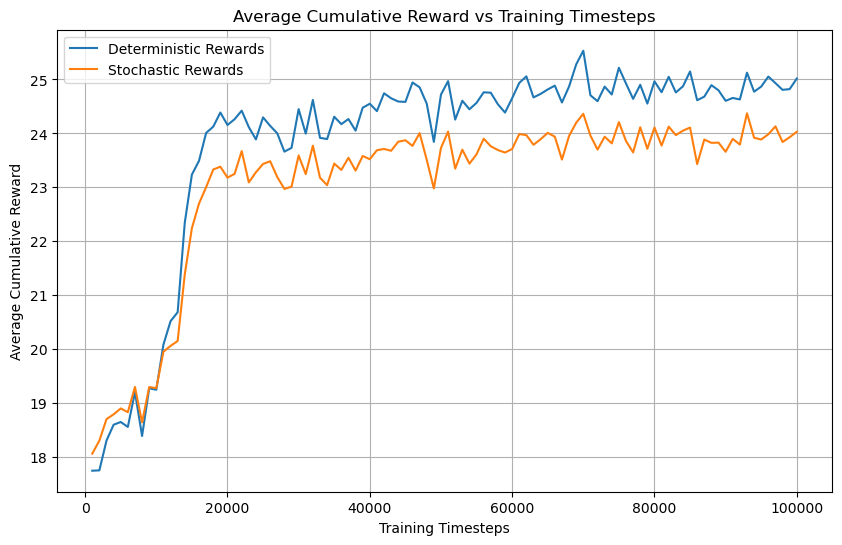

In [58]:
# 计算平均累计收益
deterministic_rewards = []
stochastic_rewards = []
timesteps = []
n_episodes = 10000
for step in range(check_freq, total_timesteps + 1, check_freq):
    print("解压:", step)
    model_filename = f'model_{step}.zip'
    model_path = os.path.join(save_path, model_filename)
    
    # 加载模型
    model = SAC.load(model_path)
    
    # 调用 get_reward_episode 函数
    deterministic_temp_reward, stochastic_temp_reward,_,_= get_reward_episode(model, env, T, n_episodes)
    
    # 记录结果
    deterministic_rewards.append(deterministic_temp_reward[T-1])
    stochastic_rewards.append(stochastic_temp_reward[T-1])
    timesteps.append(step)

# 绘制平均累计收益随训练次数的变化
plt.figure(figsize=(10, 6))
plt.plot(timesteps, deterministic_rewards, label='Deterministic Rewards')
plt.plot(timesteps, stochastic_rewards, label='Stochastic Rewards')
plt.xlabel('Training Timesteps')
plt.ylabel('Average Cumulative Reward')
plt.title('Average Cumulative Reward vs Training Timesteps')
plt.legend()
plt.grid()
plt.show()

In [59]:
# 训练的最终模型
n_episodes = 100000
model_name = SAC.load("UCB")
# 调用 get_reward_episode 函数
deterministic_rewards_mean, stochastic_rewards_mean, deterministic_alphas_mean, stochastic_alphas_mean = get_reward_episode(model_name, env, T, n_episodes,1)


/var/folders/3_/5t18rvzn7w18bdcrs_vxgxhr0000gn/T/ipykernel_17736/3102394239.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  deterministic_alphas_sum[t] += action
/var/folders/3_/5t18rvzn7w18bdcrs_vxgxhr0000gn/T/ipykernel_17736/3102394239.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  stochastic_alphas_sum[t] += action


Episode: 1
Episode: 2
Episode: 3
Episode: 4
Episode: 5
Episode: 6
Episode: 7
Episode: 8
Episode: 9
Episode: 10
Episode: 11
Episode: 12
Episode: 13
Episode: 14
Episode: 15
Episode: 16
Episode: 17
Episode: 18
Episode: 19
Episode: 20
Episode: 21
Episode: 22
Episode: 23
Episode: 24
Episode: 25
Episode: 26
Episode: 27
Episode: 28
Episode: 29
Episode: 30
Episode: 31
Episode: 32
Episode: 33
Episode: 34
Episode: 35
Episode: 36
Episode: 37
Episode: 38
Episode: 39
Episode: 40
Episode: 41
Episode: 42
Episode: 43
Episode: 44
Episode: 45
Episode: 46
Episode: 47
Episode: 48
Episode: 49
Episode: 50
Episode: 51
Episode: 52
Episode: 53
Episode: 54
Episode: 55
Episode: 56
Episode: 57
Episode: 58
Episode: 59
Episode: 60
Episode: 61
Episode: 62
Episode: 63
Episode: 64
Episode: 65
Episode: 66
Episode: 67
Episode: 68
Episode: 69
Episode: 70
Episode: 71
Episode: 72
Episode: 73
Episode: 74
Episode: 75
Episode: 76
Episode: 77
Episode: 78
Episode: 79
Episode: 80
Episode: 81
Episode: 82
Episode: 83
Episode: 84
E

In [61]:
# 定义要保存的数据
data = {
    'deterministic_rewards_mean': deterministic_rewards_mean,
    'stochastic_rewards_mean': stochastic_rewards_mean,
    'deterministic_alphas_mean': deterministic_alphas_mean,
    'stochastic_alphas_mean': stochastic_alphas_mean
}

# 保存数据到本地文件
with open('/Users/fengyilong/Git/MAB_SAC/UCB_record/data_single.pkl', 'wb') as f:
    pickle.dump(data, f)

print("数据已保存到 /Users/fengyilong/Git/MAB_SAC/UCB_record/data_single.pkl")

数据已保存到 /Users/fengyilong/Git/MAB_SAC/UCB_record/data_single.pkl


数据已从 /Users/fengyilong/Git/MAB_SAC/UCB_reccord/data_single.pkl 加载


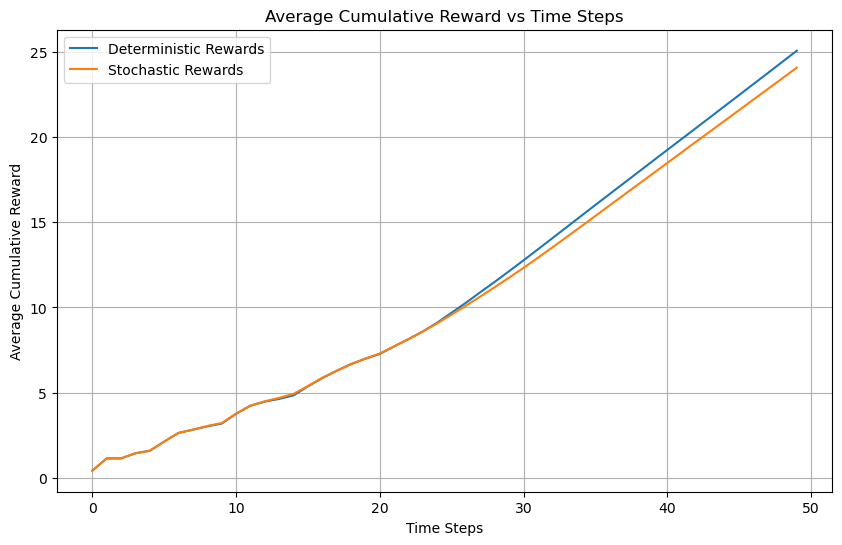

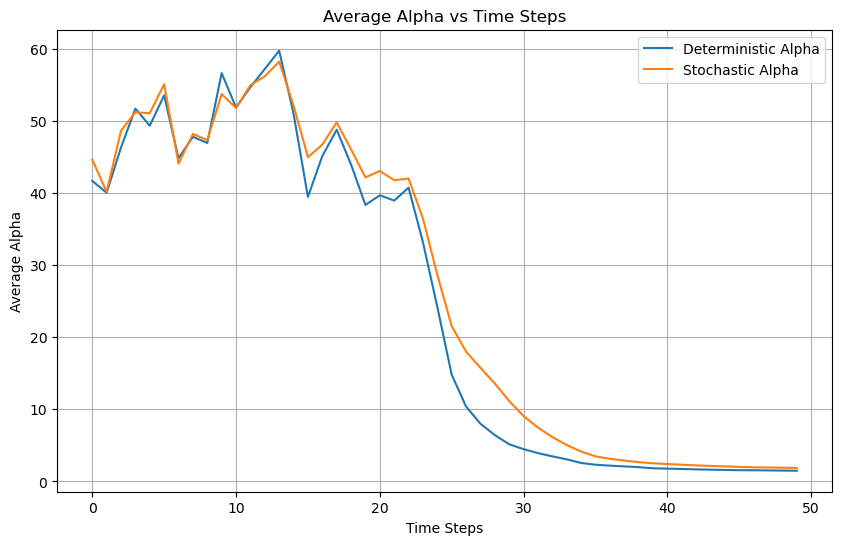

In [62]:
# 从本地文件加载数据
with open('/Users/fengyilong/Git/MAB_SAC/UCB_record/data_single.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

# 访问加载的数据
deterministic_rewards_mean = loaded_data['deterministic_rewards_mean']
stochastic_rewards_mean = loaded_data['stochastic_rewards_mean']
deterministic_alphas_mean = loaded_data['deterministic_alphas_mean']
stochastic_alphas_mean = loaded_data['stochastic_alphas_mean']

print("数据已从 /Users/fengyilong/Git/MAB_SAC/UCB_reccord/data_single.pkl 加载")

# 绘制确定策略和随机策略的每步的平均累计收益
plt.figure(figsize=(10, 6))
plt.plot(deterministic_rewards_mean, label='Deterministic Rewards')
plt.plot(stochastic_rewards_mean, label='Stochastic Rewards')
plt.xlabel('Time Steps')
plt.ylabel('Average Cumulative Reward')
plt.title('Average Cumulative Reward vs Time Steps')
plt.legend()
plt.grid()
plt.show()

# 绘制确定策略和随机策略的每步的平均alpha
plt.figure(figsize=(10, 6))
plt.plot(deterministic_alphas_mean, label='Deterministic Alpha')
plt.plot(stochastic_alphas_mean, label='Stochastic Alpha')
plt.xlabel('Time Steps')
plt.ylabel('Average Alpha')
plt.title('Average Alpha vs Time Steps')
plt.legend()
plt.grid()
plt.show()